In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from functools import partial


In [2]:
# original data
original = pd.read_csv("../../data/Airbnb/train_test.csv")
original.head()

,id,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,...,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,727,Palermo,Entire home/apt,1,170,5/12/20,2.48,4,346,8/1/13,...,2092,1,0,365,t,f,strict_14_with_grace_period,f,f,2
1,6274,Colegiales,Private room,1,11,7/1/19,0.57,1,0,2/14/14,...,558,1,0,15,f,f,moderate,f,f,1
2,6025,Recoleta,Entire home/apt,3,2,11/23/19,0.08,19,360,10/19/17,...,1052,3,351,90,t,f,moderate,f,f,3
3,8931,Recoleta,Entire home/apt,2,1,11/1/19,0.13,1,267,2/1/19,...,0,4,0,1125,t,f,flexible,f,f,2
4,7524,San Nicolás,Entire home/apt,2,31,12/26/19,1.54,5,365,1/24/15,...,2092,1,0,365,t,f,moderate,f,f,3


### Data preprocessing

In [3]:
# split data into features and labels
X_train_original = original.drop("price", axis = 1)
y_train = original["price"]

In [4]:
# check missing data
original.isnull().values.any()

False

In [5]:
# fe for feature engineering. 
# Since "id" is not useful and "is_business_travel_ready" values are the same for the training data, they are dropped.
fe = X_train_original.drop(["id","is_business_travel_ready"], axis = 1)

In [6]:
fe.head()

,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,host_is_superhost,...,beds,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Palermo,Entire home/apt,1,170,5/12/20,2.48,4,346,8/1/13,t,...,1,Real Bed,2092,1,0,365,t,strict_14_with_grace_period,f,f
1,Colegiales,Private room,1,11,7/1/19,0.57,1,0,2/14/14,t,...,1,Real Bed,558,1,0,15,f,moderate,f,f
2,Recoleta,Entire home/apt,3,2,11/23/19,0.08,19,360,10/19/17,f,...,1,Real Bed,1052,3,351,90,t,moderate,f,f
3,Recoleta,Entire home/apt,2,1,11/1/19,0.13,1,267,2/1/19,f,...,3,Real Bed,0,4,0,1125,t,flexible,f,f
4,San Nicolás,Entire home/apt,2,31,12/26/19,1.54,5,365,1/24/15,t,...,3,Real Bed,2092,1,0,365,t,moderate,f,f


In [7]:
# There are two features with time data: "last_review" and "host_since". Transfer them to datetime data
lr = fe.last_review.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y'))
hs = fe.host_since.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y'))

In [8]:
# Set a standard date to help transfer datetime data to integers
date_standard = datetime.datetime(1900, 1, 1)

In [9]:
# Transfer datetime data to integers. The data will be scaled so don't worry about the large values.
lr_diff = [(x - date_standard).days for x in lr]
hs_diff = [(x - date_standard).days for x in hs]

In [10]:
# Assign the integer values
fe.last_review = lr_diff
fe.host_since = hs_diff

In [11]:
# Reassign values in "cancellation_policy" based on the length of cancellation days. 
# A larger value means longer days needed for making cancellations (i.e., more strict policy).
fe["cancellation_policy"] = fe["cancellation_policy"].replace({"super_strict_60":5, "super_strict_30":4, "strict_14_with_grace_period":3,
                                    "moderate":2, "flexible":1})

In [12]:
fe.head()

,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,host_is_superhost,...,beds,bed_type,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,Palermo,Entire home/apt,1,170,43961,2.48,4,346,41485,t,...,1,Real Bed,2092,1,0,365,t,3,f,f
1,Colegiales,Private room,1,11,43645,0.57,1,0,41682,t,...,1,Real Bed,558,1,0,15,f,2,f,f
2,Recoleta,Entire home/apt,3,2,43790,0.08,19,360,43025,f,...,1,Real Bed,1052,3,351,90,t,2,f,f
3,Recoleta,Entire home/apt,2,1,43768,0.13,1,267,43495,f,...,3,Real Bed,0,4,0,1125,t,1,f,f
4,San Nicolás,Entire home/apt,2,31,43823,1.54,5,365,42026,t,...,3,Real Bed,2092,1,0,365,t,2,f,f


In [13]:
# Will use dummy variables for multi-class features
multi_class_features = ["neighbourhood", "room_type", "bed_type"]

In [14]:
# Concatenate dummy variables. The original variables will be deleted later.
for i in range(3):
    fe = pd.concat([fe,pd.get_dummies(fe[multi_class_features[i]])], axis = 1, sort = False)

In [15]:
fe.head()

,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,host_is_superhost,...,Vélez Sársfield,Entire home/apt,Hotel room,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,Palermo,Entire home/apt,1,170,43961,2.48,4,346,41485,t,...,0,1,0,0,0,0,0,0,0,1
1,Colegiales,Private room,1,11,43645,0.57,1,0,41682,t,...,0,0,0,1,0,0,0,0,0,1
2,Recoleta,Entire home/apt,3,2,43790,0.08,19,360,43025,f,...,0,1,0,0,0,0,0,0,0,1
3,Recoleta,Entire home/apt,2,1,43768,0.13,1,267,43495,f,...,0,1,0,0,0,0,0,0,0,1
4,San Nicolás,Entire home/apt,2,31,43823,1.54,5,365,42026,t,...,0,1,0,0,0,0,0,0,0,1


In [16]:
# Will use 0 and 1 for binary features
binary_features = ["host_is_superhost", "instant_bookable",
                "require_guest_profile_picture", "require_guest_phone_verification"]

In [17]:
# Make 0 and 1 for binary features and store them as encoded. The original variables will be deleted later.
encoder = LabelEncoder()
encoded = fe[binary_features].apply(encoder.fit_transform)
fe.head()

,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,host_is_superhost,...,Vélez Sársfield,Entire home/apt,Hotel room,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,Palermo,Entire home/apt,1,170,43961,2.48,4,346,41485,t,...,0,1,0,0,0,0,0,0,0,1
1,Colegiales,Private room,1,11,43645,0.57,1,0,41682,t,...,0,0,0,1,0,0,0,0,0,1
2,Recoleta,Entire home/apt,3,2,43790,0.08,19,360,43025,f,...,0,1,0,0,0,0,0,0,0,1
3,Recoleta,Entire home/apt,2,1,43768,0.13,1,267,43495,f,...,0,1,0,0,0,0,0,0,0,1
4,San Nicolás,Entire home/apt,2,31,43823,1.54,5,365,42026,t,...,0,1,0,0,0,0,0,0,0,1


In [18]:
# drop original multi-class and binary featuers because we have dealt with them and stores their values
fe = fe.drop(fe[multi_class_features], axis = 1).drop(fe[binary_features], axis = 1)

<AxesSubplot:>

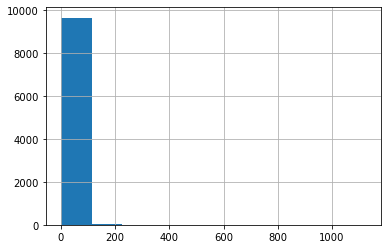

In [19]:
# Look at histograms of features that are neither binary nor multi-class
fe.iloc[:,0].hist() ## change 0 to 1,...,21 to get other histograms
# It can be seen that columns 0,1,3,4,7,8,9,10,11,12,13 need to be log-transformed 

<AxesSubplot:>

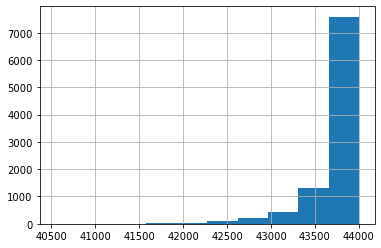

In [20]:
# and column 2 needs to be transformed based on its largest value.
fe.iloc[:,2].hist()

In [21]:
# Concatenate binary features now
data = pd.concat([fe,encoded], axis = 1, sort = False)
data.head()

,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,bathrooms,bedrooms,beds,...,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,host_is_superhost,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,1,170,43961,2.48,4,346,41485,1.0,0,1,...,0,0,0,0,0,1,1,1,0,0
1,1,11,43645,0.57,1,0,41682,1.0,1,1,...,0,0,0,0,0,1,1,0,0,0
2,3,2,43790,0.08,19,360,43025,1.0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,2,1,43768,0.13,1,267,43495,1.0,1,3,...,0,0,0,0,0,1,0,1,0,0
4,2,31,43823,1.54,5,365,42026,1.0,1,3,...,0,0,0,0,0,1,1,1,0,0


In [22]:
# log-transform the variables mentioned above
for j in [0,1,3,4,7,8,9,10,11,12,13]:
    data.iloc[:,j] = np.log([int(x) + 1 for x in data.iloc[:,j]])


In [23]:
# For column 2, do a log transform based on its largest value
max_date = max(data.iloc[:,2])
data.iloc[:,2] = np.log([int(max_date-x)+1 for x in data.iloc[:,2]])

<AxesSubplot:>

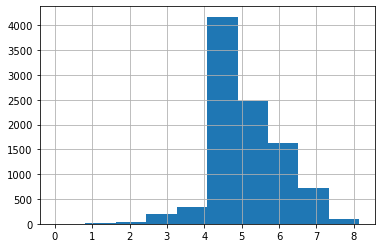

In [24]:
# Now the distribution of the histogram looks much better
data.iloc[:,2].hist() 

In [25]:
# Check how many pairs with correlation greater than 0.75 or smaller than -0.75. 
sum(np.sum(data.iloc[0:len(original),:].corr().abs() > 0.8) > 1)/2

1.0

In [26]:
# From here we see that the only pair is "Entire home/apt" and "Private room".
# However, it is not appropriate to remove one column because they are dummy variables of the same variable 
# and identifies values of that variable.
data.iloc[0:len(original),:].corr().abs().unstack().sort_values()[-76:-72]

require_guest_phone_verification  require_guest_profile_picture    0.784512
Entire home/apt                   Private room                     0.941088
Private room                      Entire home/apt                  0.941088
minimum_nights                    minimum_nights                   1.000000
dtype: float64

In [27]:
# data normalization
scaler = RobustScaler()
scaler.fit(data)

RobustScaler()

In [28]:
# store normalized data
X_train_scaled = scaler.transform(data)

We use 80% as training set and the other 20% as test set.

In [29]:
xtrain,xtest,ytrain,ytest = train_test_split(X_train_scaled, y_train, stratify=y_train, test_size = 0.2)

Under the guidance of one-vs-other classification, create dummy variables for the label to obtain four colums of labels.

In [30]:
ytrain_dummy = np.zeros((4,len(ytrain)))
for i in range(4):
    ytrain_dummy[i,:] = np.array([int(val == i+1) for val in ytrain])

In [31]:
ytrain_dummy

array([[0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Our definition of functions of the algorithms, copying from the main document writing the algorithms.

In [32]:
def sghmc(U_grad, theta_init, M, C, V_hat, epsilon, T, m):
    """
    Stochastic Gradient Hamiltonian Monte Carlo Sampling.
    Based on Chen, Tianqi, Emily Fox, and Carlos Guestrin (2014)
    --------------------
    
    Dimensions
    -----------
    d: number of parameters
    T: length of samples
    
    Input
    ------
    U_grad: callable 
        Stochastic gradient estimates of posterior density with respect to distribution parameters 
        'U_grad_tilde(D, logp_data_grad, logp_prior_grad, mb_size, theta)' when the gradient is unknown
    
    theta_init: d-by-1 np array
        The inital sampling point
        
    M: d-by-d np array
        A mass matrix
    
    C: d-by-d np array
        A user specified friction term, should be greater than B_hat = 0.5*epsilon*V_hat 
        in the sense of in the sense of positive semi-definiteness
    
    V_hat: d-by-d np array
        Empirical Fisher information of theta
        
    epsilon: float
        Step size
        
    T: int
        Number of samples drawn from the desired distribution
        
    m: int
        Number of steps for each draw
    
    
    Output
    ------
    theta_s: T-by-d np array
        Draws sampled from the desired distrition
    
    r_s: T-by-d np array
        Draws of the momentun variables
    
    """
    d = len(theta_init)
    theta_s = np.zeros((T, d))
    r_s = np.zeros((T, d))
    theta_s[0] = theta_init
    M_inv = np.linalg.inv(M)
    B_hat = 0.5*epsilon*V_hat
    
    if d > 1:
        sd = np.linalg.cholesky(2*epsilon*(C-B_hat))
        r_s = np.random.multivariate_normal(np.zeros(d),M, size = T)
    elif d==1:
        sd = np.sqrt(2*epsilon*(C-B_hat))
        r_s = np.sqrt(M)*np.random.randn(T).reshape(T,1)
    
    for t in range(T-1):
        theta0 = theta_s[t]
        r0 = r_s[t]
        for i in range(m):
            theta0 = theta0 + epsilon*np.dot(M_inv,r0)
            r0 = r0 - epsilon*U_grad(theta0) - epsilon*np.dot(np.dot(C,M_inv),r0) +  np.dot(sd,np.random.randn(d))
        theta_s[t+1] = theta0
    
    return [theta_s,r_s]


In [33]:
def U_grad_tilde(theta, data, logp_data_grad, logp_prior_grad, mb_size):
    """
    Stochastic gradient estimates of posterior density with respect to distribution parameters
    Based on a minibatch D_hat sampled uniformly at random from D
    ------------------------
    
    Dimensions
    -----------
    n: number of observations from the data
    m: dimension of the data

    Input
    -----
    D: n-by-m np array
        Dataset
        
    logp_data_grad: callable 'logp_data_grad(data, theta)'
        Gradient of likelihood of the data with respect to distribution parameters
    
    logp_prior_grad: callable 'logp_prior_grad(theta)'
        Gradient of prior with respect to distribution parameters
    
    mb_size: int
        Size of the minibatch
    
    theta: d-by-1 np array
        Distribution parameters
    
    Output
    -----
    U_tilde: d-by-1 np array
        Stochastic gradient estimates of posterior density with respect to distribution parameters
    """
    n = data.shape[0]
    data_hat = data[np.random.choice(range(n), size = mb_size, replace = False)]
    U_tilde = -(n/mb_size)*logp_data_grad(data_hat, theta) - logp_prior_grad(theta)
    return U_tilde

In [34]:
def U_tilde(theta, data, logp_data, logp_prior, mb_size):
    """
    Stochastic gradient estimates of posterior density with respect to distribution parameters
    Based on a minibatch D_hat sampled uniformly at random from D
    ------------------------
    
    Dimensions
    -----------
    n: number of observations from the data
    m: dimension of the data

    Input
    -----
    D: n-by-m np array
        Dataset
        
    logp_data: callable 'logp_data(data, theta)'
        Likelihood of the data with respect to distribution parameters
    
    logp_prior: callable 'logp_prior(theta)'
        Prior with respect to distribution parameters
    
    mb_size: int
        Size of the minibatch
    
    theta: d-by-1 np array
        Distribution parameters
    
    Output
    -----
    U_tilde: d-by-1 np array
        Stochastic gradient estimates of posterior density with respect to distribution parameters
    """
    n = data.shape[0]
    data_hat = data[np.random.choice(range(n), size = mb_size, replace = False)]
    U_tilde = -(n/mb_size)*logp_data(data_hat, theta) - logp_prior(theta)
    return U_tilde

In [35]:
def sghmc_naive(U_grad, U, theta_init, M, V_hat, epsilon, T, m, MH=True, resample=False):
    """
    Naive Stochastic Gradient Hamiltonian Monte Carlo Sampling.
    --------------------
    
    Input
    ------
    U_grad: callable 
        Stochastic gradient estimates of posterior density with respect to distribution parameters 
        'U_grad_tilde(D, logp_data_grad, logp_prior_grad, mb_size, theta)' when the gradient is unknown
    
    U: callable
        Potential energy function
    
    theta_init: d-by-1 np array
        The inital sampling point
        
    M: d-by-d np array
        A mass matrix
    
    V_hat: d-by-d np array
        Empirical Fisher information of theta
        
    epsilon: float
        Step size
    
    T: int
        Number of samples drawn from the desired distribution
        
    m: int
        Number of steps for each draw
    
    MH: Boolean
        Whether to incorporate a Metropolis-Hasting correction
    
    resample: Boolean
        Whether to resample the momentum variables 
        
    Output
    ------
    theta_s: T-by-d np array
        Draws sampled from the desired distrition
    
    r_s: T-by-d np array
        Draws of the momentun variables
    
    """
    
    d = len(theta_init)
    theta_s = np.zeros((T, d))
    theta_s[0] = theta_init
    M_inv = np.linalg.inv(M)
    B_hat = 0.5*epsilon*V_hat
    
    if d > 1:
        sd = np.linalg.cholesky(2*epsilon*B_hat)
        r_s = np.random.multivariate_normal(np.zeros(d),M, size = T)
    elif d==1:
        sd = np.sqrt(2*epsilon*B_hat)
        r_s = np.sqrt(M)*np.random.randn(T).reshape(T,1)
    
    for t in range(T-1):
        theta0 = theta_s[t]
        r0 = r_s[t]
        
        for i in range(m):
            theta0 = theta0 + epsilon*np.dot(M_inv,r0)
            r0 = r0 - epsilon*U_grad(theta0) + np.dot(sd,np.random.randn(d))
        
        ## M-H correction 
        if MH==True:
            u = np.random.rand(1)
            H1 = U(theta_s[t]) + 0.5*np.dot(np.dot(r_s[t],M_inv),r_s[t])
            H2 = U(theta0) + 0.5*np.dot(np.dot(r0,M_inv),r0)
            rho = np.exp(H1-H2)
            if u < np.minimum(1,rho):
                theta_s[t+1] = theta0
                if resample==False: 
                    r_s[t+1] = r0
            else:
                theta_s[t+1] = theta_s[t]
                if resample==False: 
                    r_s[t+1] = r_s[t]
        else:
            theta_s[t+1] = theta0
            if resample==False:
                r_s[t+1] = r0
    
    return [theta_s,r_s]

In [36]:
def hmc(U_grad, U, theta_init, M, epsilon, T, m, MH=True, resample=False):
    """
    Hamiltonian Monte Carlo Sampling.
    --------------------
    
    Input
    ------
    U_grad: callable 
        Gradient of U with respect to distribution parameters 
    
    U: callable
        Potential energy function
    
    theta_init: d-by-1 np array
        The inital sampling point
        
    M: d-by-d np array
        A mass matrix
    
    epsilon: float
        Step size
    
    T: int
        Number of samples drawn from the desired distribution
        
    m: int
        Number of steps for each draw
    
    MH: Boolean
        Whether to incorporate a Metropolis-Hasting correction
    
    resample: Boolean
        Whether to resample the momentum variables 
    
    Output
    ------
    theta_s: T-by-d np array
        Draws sampled from the desired distrition
        
    r_s: T-by-d np array
        Draws of the momentun variables
    
    """
    
    d = len(theta_init) 
    theta_s = np.zeros((T, d))
    theta_s[0] = theta_init
    M_inv = np.linalg.inv(M)

    if d > 1:
        r_s = np.random.multivariate_normal(np.zeros(d),M, size=T)
    elif d==1:
        r_s = np.sqrt(M)*np.random.randn(T).reshape(T,1)
        
    for t in range(T-1):

        theta0 = theta_s[t]
        r0 = r_s[t]
        
        ## leapfrog
        r0 = r0 - 0.5*epsilon*U_grad(theta0)
        for i in range(m-1):
            theta0 = theta0 + epsilon*np.dot(M_inv,r0)
            r0 = r0 - epsilon*U_grad(theta0)
        theta0 = theta0 + epsilon*np.dot(M_inv,r0)
        r0 = r0 - 0.5*epsilon*U_grad(theta0) 
        
        ## M-H correction 
        if MH==True:
            u = np.random.rand(1)
            H1 = U(theta_s[t]) + 0.5*np.dot(np.dot(r_s[t],M_inv),r_s[t])
            H2 = U(theta0) + 0.5*np.dot(np.dot(r0,M_inv),r0)
            rho = np.exp(H1-H2)
            if u < np.minimum(1,rho):
                theta_s[t+1] = theta0
                if resample==False: 
                    r_s[t+1] = r0
            else:
                theta_s[t+1] = theta_s[t]
                if resample==False: 
                    r_s[t+1] = r_s[t]
        else:
            theta_s[t+1] = theta0
            if resample==False:
                r_s[t+1] = r0

    return [theta_s,r_s]

Going back to the Airbnb data

In [37]:
p = len(xtrain[0])
size = len(xtrain)

Preparation for SGHMC

In [38]:
logp_prior_grad = lambda theta: 0 # uniform prior

def logp_data_grad(data, theta):
    """
    Gradient of log likelihood of a linear regression 
    --------------
    
    Assume that the first column of the data is the predicted variable
    """
    X = data[:,1:]
    y = data[:,0]
    return np.dot(X.T,y) - np.dot(np.dot(X.T,X),theta)

In [39]:
M = np.eye(p)
C = 13*np.eye(p)
V_hat = np.eye(p) / (size-1)
T = 1000
m = 50
epsilon = 0.001

Applying SGHMC. The comments are suitable for the other two algorithms below, so we only providee the comments for SGHMC.

In [40]:
theta_vals = np.zeros((4,T,p)) # To record samples of theta values
for i in range(4):
    data = np.c_[ytrain_dummy[i,:],xtrain]
    gradU = partial(U_grad_tilde, data=data, logp_data_grad=logp_data_grad, logp_prior_grad=logp_prior_grad, mb_size=100)
    theta_init = np.zeros(p)
    theta_sghmc4, r_sghmc4 = sghmc(gradU, theta_init, M, C, V_hat, epsilon, T, m) # Get theta values of shape (T,p)
    theta_cumsum = theta_sghmc4.cumsum(axis=0)  # Get cumulative theta values in each step
    theta_vals[i,:,:] = theta_cumsum # Record theta values
    
# Note that we will take the maximum of the four theta values from four label columns. 
# Therefore, although the mean theta values are our estimation of theta,
# it is not necessary to transform cumulative theta values to mean theta values 
# (i.e., dividing the value by the number of steps).

In [41]:
theta_vals2 = theta_vals.transpose(1,2,0) # Now the shape is (T,p,4)

In [42]:
accs = np.zeros(T) # To record accuracies for each step
for t in range(T):
    test_pred_vals = xtest @ theta_vals2[t] # Predicted labels of shape (size,4)
    test_pred = np.zeros_like(test_pred_vals) # For each row of data, record which one among four is the largest 
    test_pred[np.arange(len(test_pred_vals)), test_pred_vals.argmax(1)] = 1 # Set the largset to be 1, others to be 0
    testpred = np.array([np.argmax(test_pred[i])+1 for i in range(len(test_pred_vals))]) # Transfer to the 1-4 scale
    accs[t] = sum(testpred == ytest)/len(ytest) # Record accuracy
    

Preparation for naive SGHMC

In [43]:
logp_prior = lambda theta: 0 # uniform prior

def logp_data(data, theta):
    """
    log likelihood of a linear regression 
    --------------
    
    Assume that the first column of the data is the predicted variable
    """
    X = data[:,1:]
    y = data[:,0]
    return 0.5 * (y - X @ theta).T @ (y - X @ theta)

In [44]:
V_hat = np.eye(p) / (size-1)

Applying naive SGHMC

In [45]:
theta_sghmc_naive_vals = np.zeros((4,T,p))
for i in range(4):
    data = np.c_[ytrain_dummy[i,:],xtrain]
    U = partial(U_tilde, data=data, logp_data=logp_data, logp_prior=logp_prior, mb_size=100)
    gradU = partial(U_grad_tilde, data=data, logp_data_grad=logp_data_grad, logp_prior_grad=logp_prior_grad, mb_size=100)
    theta_init = np.zeros(p)
    theta_sghmc_naive4, r_sghmc_naive4 = sghmc_naive(gradU, U, theta_init, M, V_hat, epsilon, T, m)
    theta_sghmc_naive_cumsum = theta_sghmc_naive4.cumsum(axis=0)  
    theta_sghmc_naive_vals[i,:,:] = theta_sghmc_naive_cumsum

<ipython-input-35-33f1711305c4>:75: RuntimeWarning: overflow encountered in exp
  rho = np.exp(H1-H2)


In [46]:
theta_sghmc_naive_vals2 = theta_sghmc_naive_vals.transpose(1,2,0)

In [47]:
accs_naive = np.zeros(T)
for t in range(T):
    test_pred_vals = xtest @ theta_sghmc_naive_vals2[t]
    test_pred = np.zeros_like(test_pred_vals)
    test_pred[np.arange(len(test_pred_vals)), test_pred_vals.argmax(1)] = 1
    testpred = np.array([np.argmax(test_pred[i])+1 for i in range(len(test_pred_vals))])
    accs_naive[t] = sum(testpred == ytest)/len(ytest)

Preparation for HMC and applying HMC

In [48]:
theta_hmc_vals = np.zeros((4,T,p))
for i in range(4):
    data = np.c_[ytrain_dummy[i,:],xtrain]
    U = partial(U_tilde, data=data, logp_data=logp_data, logp_prior=logp_prior, mb_size=100)
    gradU = partial(U_grad_tilde, data=data, logp_data_grad=logp_data_grad, logp_prior_grad=logp_prior_grad, mb_size=100)
    theta_init = np.zeros(p)
    theta_hmc4, r_hmc4 = hmc(gradU, U, theta_init, M, epsilon, T, m)
    theta_hmc_cumsum = theta_hmc4.cumsum(axis=0)  
    theta_hmc_vals[i,:,:] = theta_hmc_cumsum

<ipython-input-36-ce5166f19b16>:73: RuntimeWarning: overflow encountered in exp
  rho = np.exp(H1-H2)


In [49]:
theta_hmc_vals2 = theta_hmc_vals.transpose(1,2,0)

In [50]:
accs_hmc = np.zeros(T)
for t in range(T):
    test_pred_vals = xtest @ theta_hmc_vals2[t]
    test_pred = np.zeros_like(test_pred_vals)
    test_pred[np.arange(len(test_pred_vals)), test_pred_vals.argmax(1)] = 1
    testpred = np.array([np.argmax(test_pred[i])+1 for i in range(len(test_pred_vals))])
    accs_hmc[t] = sum(testpred == ytest)/len(ytest)

Plot the accuracies

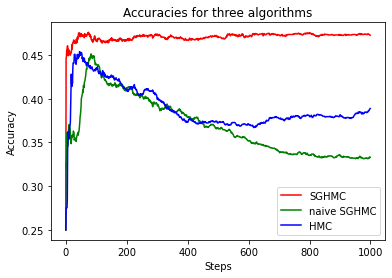

In [51]:
plt.plot(accs,c='r',label="SGHMC")
plt.plot(accs_naive,c='g',label="naive SGHMC")
plt.plot(accs_hmc,c='b',label="HMC")
plt.title("Accuracies for three algorithms")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()